## Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils
import scipy.sparse
import gensim

## Read-In Data

In [2]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')
print(f'Pospar: {pospar.shape}')

Health: (30616, 8)
ObsGyn: (92943, 8)
Pospar: (49094, 8)


## Define Stop Words

In [3]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [4]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix From Corpus

#### Function

In [5]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create Document Term Matrix

In [99]:
health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
health_vectorizer_f, health_dtm_f = build_tvec(health_filtered, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')
pospar_vectorizer, pospar_dtm = build_tvec(pospar, 'lemma_text')

#### Transform Document Term Matrix into a Term Document Matrix that can be recognized by Gensim

In [7]:
def create_tdm(dtm):
    tdm = dtm.transpose()
    return tdm

In [8]:
def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

In [9]:
def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

In [101]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
health_corpus_f = prepare_dtm_for_gensim(health_dtm_f)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)
pospar_corpus = prepare_dtm_for_gensim(pospar_dtm)

## Define Vocabulary Dictionary from Vectorizer

In [11]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [100]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
health_vocabulary_f = create_vocab_dictionary(health_vectorizer_f)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)
pospar_vocabulary = create_vocab_dictionary(pospar_vectorizer)

## Build LSA Models

In [13]:
def build_gensim_lsa(dtm, dictionary, n_topics):
    lsa = LsiModel(dtm, num_topics = n_topics, id2word = dictionary)
    return lsa   

In [14]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model=model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return coherence.get_coherence()

In [21]:
def grid_search_lsa(df, column, stopwords, start, stop, step_size):
    clean_text, dictionary, dtm = gensim_preprocessing(df, column, stopwords)
    
    models_dict = {}
    coherence_list = []
    
    for i in range(start, stop, step_size):
        print(f'Building LSA model for {i} topics')
        lsa_model = build_gensim_lsa(dtm, dictionary, i)
        models_dict[i] = lsa_model
        print('Calculating coherence score')
        coherence = build_gensim_coherence_model(lsa_model, corpus, dictionary)
        coherence_list.append(coherence)
    
    print('Finished!')
    
    return models_dict, coherence_list

In [57]:
def grid_search_lda(corpus, vocabulary, n_passes, start, stop, step_size):
    
    models_dict = {}
    coherence_list = []
    perplexity_list = []
    
    for i in range(start, stop, step_size):
        print(f'Building LDA model for {i} topics')
        lda_model = build_gensim_lda(corpus, i, vocabulary, n_passes)
        models_dict[i] = lda_model
        print('Calculating coherence score')
        coherence = build_gensim_coherence_model(lda_model, corpus, vocabulary)
        coherence_list.append(coherence)
        perplexity = lda_model.log_perplexity(corpus)
        perplexity_list.append(perplexity)
    
    print('Finished!')
    
    return models_dict, coherence_list, perplexity_list

In [16]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

## Build LDA Models

In [17]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes)
    return lda

In [72]:
# def build_gensim_lda_mallet(corpus, n_topics, vocabulary, n_passes):
#     mallet_path = '../wrappers/mallet-2.0.8/bin/mallet'
#     lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = n_topics, id2word = vocabulary, iterations = n_passes)
#     return lda_mallet

In [18]:
# lda_model_1 = build_gensim_lda(health_corpus, 
#                                n_topics = 17, 
#                                vocabulary = health_vocabulary, 
#                                n_passes = 50)

In [19]:
# get_topic_terms(lda_model_1, 17, 10)

[(0,
  '0.014*"smell" + 0.013*"vagina" + 0.010*"jean" + 0.009*"wash" + 0.009*"shower" + 0.008*"labia" + 0.008*"skin" + 0.008*"sex" + 0.007*"use" + 0.007*"hurt"'),
 (1,
  '0.047*"period" + 0.015*"pill" + 0.014*"bleed" + 0.012*"start" + 0.011*"pregnancy" + 0.010*"late" + 0.010*"test" + 0.010*"normal" + 0.010*"pregnant" + 0.010*"cycle"'),
 (2,
  '0.059*"control" + 0.059*"birth control" + 0.058*"birth" + 0.045*"pill" + 0.021*"coworker" + 0.017*"sex" + 0.014*"condom" + 0.013*"control pill" + 0.013*"effect" + 0.013*"guilty"'),
 (3,
  '0.019*"hair" + 0.016*"look" + 0.008*"wear" + 0.008*"face" + 0.007*"weight" + 0.007*"work" + 0.007*"try" + 0.007*"body" + 0.006*"help" + 0.006*"job"'),
 (4,
  '0.096*"iud" + 0.085*"wedding" + 0.065*"tampon" + 0.058*"cup" + 0.044*"cheap" + 0.040*"roommate" + 0.036*"menstrual" + 0.035*"pad" + 0.028*"copper" + 0.028*"menstrual cup"'),
 (5,
  '0.204*"makeup" + 0.143*"nail" + 0.090*"dye" + 0.078*"outfit" + 0.064*"graduate" + 0.043*"close friend" + 0.041*"personality"

In [20]:
# build_gensim_coherence_model(lda_model_1, corpus = health_corpus, dictionary = health_vocabulary)

-3.5556879294440793

In [102]:
%time

health_lda_models_f, health_lda_coherence_f, health_lda_perplexity_f = grid_search_lda(corpus = health_corpus_f, vocabulary = health_vocabulary_f, n_passes = 25, start = 2, stop = 20, step_size = 2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Building LDA model for 2 topics
Calculating coherence score
Building LDA model for 4 topics
Calculating coherence score
Building LDA model for 6 topics
Calculating coherence score
Building LDA model for 8 topics
Calculating coherence score
Building LDA model for 10 topics
Calculating coherence score
Building LDA model for 12 topics
Calculating coherence score
Building LDA model for 14 topics
Calculating coherence score
Building LDA model for 16 topics
Calculating coherence score
Building LDA model for 18 topics
Calculating coherence score
Finished!


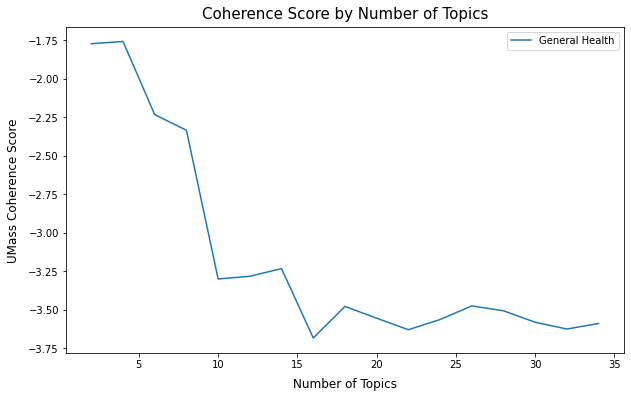

In [60]:
plt.figure(figsize = (10, 6))
sns.lineplot(x = range(2, 36, 2), y = health_lda_co  herence, label = 'General Health')
plt.xlabel('Number of Topics', fontdict = {'fontsize':12}, labelpad = 8)
plt.ylabel('UMass Coherence Score', fontdict = {'fontsize':12}, labelpad = 8)
plt.title('Coherence Score by Number of Topics', fontdict = {'fontsize':15}, pad = 8);

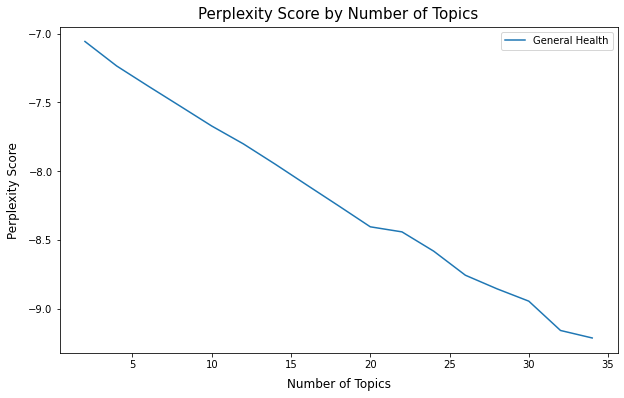

In [61]:
plt.figure(figsize = (10, 6))
sns.lineplot(x = range(2, 36, 2), y = health_lda_perplexity, label = 'General Health')
plt.xlabel('Number of Topics', fontdict = {'fontsize':12}, labelpad = 8)
plt.ylabel('Perplexity Score', fontdict = {'fontsize':12}, labelpad = 8)
plt.title('Perplexity Score by Number of Topics', fontdict = {'fontsize':15}, pad = 8);

In [74]:
lda_2 = health_lda_models[2]
lda_4 = health_lda_models[4]
lda_6 = health_lda_models[6]

print(get_topic_terms(lda_2, 2, 25))
# print()
#print(get_topic_terms(lda_4, 4, 10))
# print()
#print(get_topic_terms(lda_6, 6, 10))

[(0, '0.019*"period" + 0.010*"sex" + 0.009*"pill" + 0.008*"pain" + 0.008*"control" + 0.007*"start" + 0.007*"normal" + 0.007*"birth" + 0.007*"doctor" + 0.007*"birth control" + 0.006*"experience" + 0.006*"come" + 0.006*"test" + 0.005*"iud" + 0.005*"ago" + 0.005*"pregnant" + 0.005*"infection" + 0.005*"bleed" + 0.005*"discharge" + 0.005*"help" + 0.004*"happen" + 0.004*"cramp" + 0.004*"vagina" + 0.004*"spot" + 0.004*"blood"'), (1, '0.011*"hair" + 0.008*"look" + 0.008*"friend" + 0.007*"work" + 0.007*"good" + 0.007*"wear" + 0.006*"guy" + 0.006*"try" + 0.006*"people" + 0.006*"thing" + 0.006*"help" + 0.005*"girl" + 0.005*"tip" + 0.005*"need" + 0.005*"find" + 0.005*"way" + 0.005*"talk" + 0.005*"love" + 0.004*"ask" + 0.004*"life" + 0.004*"woman" + 0.004*"tell" + 0.004*"advice" + 0.004*"job" + 0.004*"date"')]


In [63]:
transformed_health_corpus = lda_2[health_corpus]

In [64]:
for topic in transformed_health_corpus:
    print(topic)

[(0, 0.87151855), (1, 0.12848142)]
[(0, 0.88509494), (1, 0.11490509)]
[(0, 0.7697548), (1, 0.2302452)]
[(0, 0.88448244), (1, 0.115517594)]
[(0, 0.8149874), (1, 0.18501258)]
[(0, 0.5152464), (1, 0.48475358)]
[(0, 0.8655684), (1, 0.1344316)]
[(0, 0.84029114), (1, 0.15970892)]
[(0, 0.8991317), (1, 0.100868315)]
[(0, 0.5039555), (1, 0.49604452)]
[(0, 0.12276036), (1, 0.87723964)]
[(0, 0.82214224), (1, 0.1778578)]
[(0, 0.8209995), (1, 0.1790005)]
[(0, 0.76635146), (1, 0.2336486)]
[(0, 0.34879944), (1, 0.65120053)]
[(0, 0.9031522), (1, 0.09684781)]
[(0, 0.89222497), (1, 0.10777505)]
[(0, 0.88691735), (1, 0.11308263)]
[(0, 0.74068356), (1, 0.25931647)]
[(0, 0.90037173), (1, 0.09962826)]
[(0, 0.90445083), (1, 0.09554916)]
[(0, 0.72280633), (1, 0.2771937)]
[(0, 0.8749689), (1, 0.12503114)]
[(0, 0.2706535), (1, 0.72934645)]
[(0, 0.3708044), (1, 0.62919563)]
[(0, 0.7780999), (1, 0.22190009)]
[(0, 0.7802326), (1, 0.2197674)]
[(0, 0.8365343), (1, 0.1634657)]
[(0, 0.7397405), (1, 0.26025954)]
[(0, 0

[(0, 0.7883032), (1, 0.21169677)]
[(0, 0.8181713), (1, 0.18182865)]
[(0, 0.7727755), (1, 0.22722448)]
[(0, 0.5891524), (1, 0.41084763)]
[(0, 0.891248), (1, 0.10875204)]
[(0, 0.76303005), (1, 0.23696996)]
[(0, 0.6966135), (1, 0.3033865)]
[(0, 0.70906144), (1, 0.29093856)]
[(0, 0.87456274), (1, 0.12543729)]
[(0, 0.38947615), (1, 0.6105238)]
[(0, 0.54969853), (1, 0.4503014)]
[(0, 0.85996455), (1, 0.14003547)]
[(0, 0.8107629), (1, 0.18923707)]
[(0, 0.7119849), (1, 0.28801507)]
[(0, 0.23545504), (1, 0.76454496)]
[(0, 0.75836873), (1, 0.2416313)]
[(0, 0.8824855), (1, 0.11751445)]
[(0, 0.75578046), (1, 0.24421954)]
[(0, 0.55605733), (1, 0.4439427)]
[(0, 0.6481054), (1, 0.35189465)]
[(0, 0.7125618), (1, 0.28743818)]
[(0, 0.8185002), (1, 0.1814998)]
[(0, 0.7968197), (1, 0.20318028)]
[(0, 0.8837056), (1, 0.11629437)]
[(0, 0.74871635), (1, 0.25128362)]
[(0, 0.8483492), (1, 0.15165077)]
[(0, 0.5442138), (1, 0.4557862)]
[(0, 0.80875605), (1, 0.19124396)]
[(0, 0.67463124), (1, 0.32536876)]
[(0, 0.89

[(0, 0.7469954), (1, 0.25300458)]
[(0, 0.7499711), (1, 0.25002894)]
[(0, 0.8513567), (1, 0.14864331)]
[(0, 0.7472954), (1, 0.2527046)]
[(0, 0.8026339), (1, 0.1973662)]
[(0, 0.72740954), (1, 0.27259043)]
[(0, 0.8465227), (1, 0.15347736)]
[(0, 0.78283685), (1, 0.21716313)]
[(0, 0.38815337), (1, 0.6118466)]
[(0, 0.6980809), (1, 0.3019191)]
[(0, 0.5755526), (1, 0.42444742)]
[(0, 0.85995495), (1, 0.14004508)]
[(0, 0.6471186), (1, 0.35288137)]
[(0, 0.7365995), (1, 0.2634005)]
[(0, 0.88768923), (1, 0.11231078)]
[(0, 0.23108129), (1, 0.7689187)]
[(0, 0.5461595), (1, 0.45384052)]
[(0, 0.8053595), (1, 0.19464049)]
[(0, 0.7727443), (1, 0.22725566)]
[(0, 0.8599676), (1, 0.14003241)]
[(0, 0.84647024), (1, 0.1535298)]
[(0, 0.9061866), (1, 0.093813404)]
[(0, 0.71447206), (1, 0.28552797)]
[(0, 0.61436814), (1, 0.38563183)]
[(0, 0.65310925), (1, 0.34689075)]
[(0, 0.8529818), (1, 0.14701821)]
[(0, 0.86484164), (1, 0.13515835)]
[(0, 0.6214926), (1, 0.37850744)]
[(0, 0.8512572), (1, 0.14874281)]
[(0, 0.88

[(0, 0.8293135), (1, 0.17068648)]
[(0, 0.2733878), (1, 0.7266122)]
[(0, 0.8366757), (1, 0.16332436)]
[(0, 0.8786133), (1, 0.12138666)]
[(0, 0.63017845), (1, 0.3698215)]
[(0, 0.89950526), (1, 0.10049472)]
[(0, 0.25815925), (1, 0.7418407)]
[(0, 0.5300684), (1, 0.4699316)]
[(0, 0.8838676), (1, 0.11613238)]
[(0, 0.49446806), (1, 0.50553197)]
[(0, 0.8698424), (1, 0.13015758)]
[(0, 0.5906419), (1, 0.40935808)]
[(0, 0.13797262), (1, 0.8620274)]
[(0, 0.15194657), (1, 0.84805346)]
[(0, 0.7458721), (1, 0.25412792)]
[(0, 0.76636815), (1, 0.23363186)]
[(0, 0.79719883), (1, 0.20280117)]
[(0, 0.6223609), (1, 0.37763914)]
[(0, 0.37084848), (1, 0.62915146)]
[(0, 0.26758566), (1, 0.7324143)]
[(0, 0.7288632), (1, 0.2711368)]
[(0, 0.91964424), (1, 0.080355786)]
[(0, 0.83543897), (1, 0.16456102)]
[(0, 0.86950165), (1, 0.13049829)]
[(0, 0.91234916), (1, 0.08765086)]
[(0, 0.62156963), (1, 0.3784304)]
[(0, 0.7044263), (1, 0.2955737)]
[(0, 0.38845065), (1, 0.6115493)]
[(0, 0.73205215), (1, 0.2679479)]
[(0, 0.

[(0, 0.6226851), (1, 0.3773149)]
[(0, 0.4971314), (1, 0.50286865)]
[(0, 0.5447078), (1, 0.4552922)]
[(0, 0.8045563), (1, 0.19544367)]
[(0, 0.6883293), (1, 0.31167066)]
[(0, 0.82995015), (1, 0.17004982)]
[(0, 0.15055346), (1, 0.84944654)]
[(0, 0.5184077), (1, 0.48159224)]
[(0, 0.83562845), (1, 0.1643715)]
[(0, 0.77689993), (1, 0.2231001)]
[(0, 0.41965097), (1, 0.580349)]
[(0, 0.12300624), (1, 0.8769938)]
[(0, 0.6631856), (1, 0.3368144)]
[(0, 0.7820519), (1, 0.21794814)]
[(0, 0.77107704), (1, 0.22892301)]
[(0, 0.81229216), (1, 0.1877078)]
[(0, 0.7849573), (1, 0.21504274)]
[(0, 0.39396653), (1, 0.6060335)]
[(0, 0.7366171), (1, 0.2633829)]
[(0, 0.8559426), (1, 0.14405742)]
[(0, 0.8644942), (1, 0.13550577)]
[(0, 0.89621305), (1, 0.10378699)]
[(0, 0.7226673), (1, 0.27733275)]
[(0, 0.73664796), (1, 0.26335207)]
[(0, 0.6067346), (1, 0.3932654)]
[(0, 0.7391846), (1, 0.2608154)]
[(0, 0.81365234), (1, 0.18634762)]
[(0, 0.5520366), (1, 0.44796342)]
[(0, 0.56701076), (1, 0.43298927)]
[(0, 0.4969686

[(0, 0.8918572), (1, 0.108142786)]
[(0, 0.85187435), (1, 0.1481256)]
[(0, 0.89843184), (1, 0.10156819)]
[(0, 0.4121224), (1, 0.5878776)]
[(0, 0.6082275), (1, 0.39177254)]
[(0, 0.7372833), (1, 0.26271668)]
[(0, 0.72172093), (1, 0.27827907)]
[(0, 0.8690582), (1, 0.13094184)]
[(0, 0.8310593), (1, 0.16894074)]
[(0, 0.76101774), (1, 0.2389822)]
[(0, 0.86133194), (1, 0.13866812)]
[(0, 0.5820934), (1, 0.41790658)]
[(0, 0.64430034), (1, 0.3556996)]
[(0, 0.65383303), (1, 0.34616703)]
[(0, 0.65544355), (1, 0.34455648)]
[(0, 0.12964574), (1, 0.8703543)]
[(0, 0.8783791), (1, 0.121620834)]
[(0, 0.82087976), (1, 0.17912024)]
[(0, 0.7004245), (1, 0.29957545)]
[(0, 0.8418418), (1, 0.15815823)]
[(0, 0.52211994), (1, 0.47788003)]
[(0, 0.2500506), (1, 0.7499494)]
[(0, 0.8630201), (1, 0.13697991)]
[(0, 0.6836383), (1, 0.31636167)]
[(0, 0.65626794), (1, 0.3437321)]
[(0, 0.85073644), (1, 0.1492636)]
[(0, 0.56276375), (1, 0.43723625)]
[(0, 0.8962824), (1, 0.10371766)]
[(0, 0.68265903), (1, 0.317341)]
[(0, 0.

[(0, 0.28158128), (1, 0.7184187)]
[(0, 0.7275572), (1, 0.27244276)]
[(0, 0.21075803), (1, 0.7892419)]
[(0, 0.6225452), (1, 0.37745488)]
[(0, 0.78815204), (1, 0.21184795)]
[(0, 0.73873585), (1, 0.26126415)]
[(0, 0.60079277), (1, 0.39920726)]
[(0, 0.88221145), (1, 0.117788546)]
[(0, 0.88074684), (1, 0.11925319)]
[(0, 0.8533774), (1, 0.14662258)]
[(0, 0.69941306), (1, 0.30058694)]
[(0, 0.8693407), (1, 0.13065933)]
[(0, 0.80111486), (1, 0.19888511)]
[(0, 0.54016125), (1, 0.45983878)]
[(0, 0.8944444), (1, 0.1055556)]
[(0, 0.8137434), (1, 0.18625663)]
[(0, 0.5653822), (1, 0.4346178)]
[(0, 0.82418644), (1, 0.17581359)]
[(0, 0.81346875), (1, 0.18653123)]
[(0, 0.5), (1, 0.5)]
[(0, 0.24833095), (1, 0.751669)]
[(0, 0.25039786), (1, 0.74960214)]
[(0, 0.32812804), (1, 0.67187196)]
[(0, 0.7261309), (1, 0.2738691)]
[(0, 0.41133025), (1, 0.5886697)]
[(0, 0.46903655), (1, 0.5309635)]
[(0, 0.7709013), (1, 0.22909866)]
[(0, 0.5185603), (1, 0.48143968)]
[(0, 0.89021), (1, 0.109790035)]
[(0, 0.0897497), (1

[(0, 0.58957726), (1, 0.41042277)]
[(0, 0.86953574), (1, 0.13046429)]
[(0, 0.8085481), (1, 0.1914519)]
[(0, 0.5324093), (1, 0.46759072)]
[(0, 0.72228026), (1, 0.2777197)]
[(0, 0.8224664), (1, 0.17753364)]
[(0, 0.6317966), (1, 0.36820343)]
[(0, 0.6277165), (1, 0.37228346)]
[(0, 0.5253348), (1, 0.4746652)]
[(0, 0.86363006), (1, 0.1363699)]
[(0, 0.82433426), (1, 0.17566574)]
[(0, 0.8832169), (1, 0.116783135)]
[(0, 0.48206028), (1, 0.5179396)]
[(0, 0.57450926), (1, 0.42549077)]
[(0, 0.82324797), (1, 0.17675203)]
[(0, 0.67668295), (1, 0.32331705)]
[(0, 0.7628562), (1, 0.23714384)]
[(0, 0.76560074), (1, 0.23439927)]
[(0, 0.8287066), (1, 0.17129338)]
[(0, 0.723741), (1, 0.27625903)]
[(0, 0.8547928), (1, 0.14520723)]
[(0, 0.6711057), (1, 0.32889432)]
[(0, 0.34050897), (1, 0.65949106)]
[(0, 0.5260859), (1, 0.47391406)]
[(0, 0.8609731), (1, 0.1390269)]
[(0, 0.8952788), (1, 0.1047212)]
[(0, 0.8267472), (1, 0.17325285)]
[(0, 0.2655497), (1, 0.73445034)]
[(0, 0.688838), (1, 0.31116197)]
[(0, 0.5188

[(0, 0.7712201), (1, 0.22877993)]
[(0, 0.8022688), (1, 0.19773117)]
[(0, 0.84367895), (1, 0.15632103)]
[(0, 0.837611), (1, 0.162389)]
[(0, 0.6605947), (1, 0.3394053)]
[(0, 0.78518933), (1, 0.2148107)]
[(0, 0.6694072), (1, 0.33059278)]
[(0, 0.8744399), (1, 0.12556016)]
[(0, 0.85625297), (1, 0.14374703)]
[(0, 0.73655826), (1, 0.26344174)]
[(0, 0.45010415), (1, 0.5498958)]
[(0, 0.1490405), (1, 0.85095954)]
[(0, 0.58903277), (1, 0.41096723)]
[(0, 0.71674526), (1, 0.2832547)]
[(0, 0.8130596), (1, 0.1869404)]
[(0, 0.18632647), (1, 0.8136735)]
[(0, 0.55919176), (1, 0.4408083)]
[(0, 0.84359723), (1, 0.15640278)]
[(0, 0.8991558), (1, 0.100844234)]
[(0, 0.7344544), (1, 0.26554555)]
[(0, 0.69056493), (1, 0.30943513)]
[(0, 0.17083083), (1, 0.82916915)]
[(0, 0.47893527), (1, 0.52106476)]
[(0, 0.6875699), (1, 0.31243008)]
[(0, 0.72532654), (1, 0.27467343)]
[(0, 0.774755), (1, 0.22524503)]
[(0, 0.39676735), (1, 0.6032327)]
[(0, 0.8651234), (1, 0.1348766)]
[(0, 0.9004324), (1, 0.09956763)]
[(0, 0.8959

[(0, 0.15666495), (1, 0.84333503)]
[(0, 0.20125297), (1, 0.798747)]
[(0, 0.87436813), (1, 0.1256319)]
[(0, 0.8483395), (1, 0.15166047)]
[(0, 0.8429807), (1, 0.1570193)]
[(0, 0.6140723), (1, 0.38592765)]
[(0, 0.7717979), (1, 0.22820206)]
[(0, 0.6460666), (1, 0.35393342)]
[(0, 0.17747067), (1, 0.8225293)]
[(0, 0.82443315), (1, 0.17556691)]
[(0, 0.6827052), (1, 0.31729478)]
[(0, 0.44824132), (1, 0.55175865)]
[(0, 0.81324244), (1, 0.1867576)]
[(0, 0.83640504), (1, 0.16359498)]
[(0, 0.8382782), (1, 0.1617219)]
[(0, 0.5148486), (1, 0.48515144)]
[(0, 0.88514924), (1, 0.114850774)]
[(0, 0.8206417), (1, 0.17935829)]
[(0, 0.7370146), (1, 0.26298544)]
[(0, 0.8014949), (1, 0.19850513)]
[(0, 0.7406806), (1, 0.25931945)]
[(0, 0.72494537), (1, 0.27505463)]
[(0, 0.8829692), (1, 0.11703075)]
[(0, 0.24147011), (1, 0.7585299)]
[(0, 0.8217034), (1, 0.17829664)]
[(0, 0.62991214), (1, 0.37008783)]
[(0, 0.13934079), (1, 0.8606592)]
[(0, 0.85392624), (1, 0.14607379)]
[(0, 0.8501432), (1, 0.14985676)]
[(0, 0.4

[(0, 0.8661554), (1, 0.13384463)]
[(0, 0.7704146), (1, 0.22958542)]
[(0, 0.12137397), (1, 0.878626)]
[(0, 0.6194353), (1, 0.38056466)]
[(0, 0.7391744), (1, 0.2608255)]
[(0, 0.8764583), (1, 0.12354176)]
[(0, 0.83718425), (1, 0.16281575)]
[(0, 0.56079566), (1, 0.43920434)]
[(0, 0.47555417), (1, 0.52444583)]
[(0, 0.4235288), (1, 0.5764712)]
[(0, 0.8612824), (1, 0.1387176)]
[(0, 0.82174456), (1, 0.17825547)]
[(0, 0.8600971), (1, 0.1399029)]
[(0, 0.6632098), (1, 0.33679017)]
[(0, 0.8383515), (1, 0.16164854)]
[(0, 0.9061232), (1, 0.09387677)]
[(0, 0.42750114), (1, 0.5724989)]
[(0, 0.77412593), (1, 0.22587414)]
[(0, 0.85347307), (1, 0.14652695)]
[(0, 0.51406616), (1, 0.48593384)]
[(0, 0.7221195), (1, 0.27788043)]
[(0, 0.90844715), (1, 0.09155284)]
[(0, 0.8058317), (1, 0.19416833)]
[(0, 0.85975975), (1, 0.14024028)]
[(0, 0.69489944), (1, 0.30510056)]
[(0, 0.81266356), (1, 0.1873365)]
[(0, 0.5552891), (1, 0.4447109)]
[(0, 0.3368308), (1, 0.6631692)]
[(0, 0.8314229), (1, 0.16857708)]
[(0, 0.1482

[(0, 0.73443806), (1, 0.2655619)]
[(0, 0.32179028), (1, 0.6782097)]
[(0, 0.7990573), (1, 0.20094271)]
[(0, 0.8048123), (1, 0.1951877)]
[(0, 0.7223129), (1, 0.2776871)]
[(0, 0.8479646), (1, 0.15203542)]
[(0, 0.83864576), (1, 0.16135423)]
[(0, 0.6993783), (1, 0.30062166)]
[(0, 0.88739985), (1, 0.11260012)]
[(0, 0.86715585), (1, 0.13284412)]
[(0, 0.7062871), (1, 0.29371297)]
[(0, 0.3263143), (1, 0.67368567)]
[(0, 0.63622534), (1, 0.36377472)]
[(0, 0.85384995), (1, 0.14615004)]
[(0, 0.6801569), (1, 0.3198431)]
[(0, 0.6846221), (1, 0.31537786)]
[(0, 0.34323904), (1, 0.65676093)]
[(0, 0.85906047), (1, 0.14093956)]
[(0, 0.5586764), (1, 0.4413236)]
[(0, 0.3669124), (1, 0.6330876)]
[(0, 0.8093187), (1, 0.19068126)]
[(0, 0.5523335), (1, 0.44766656)]
[(0, 0.8779342), (1, 0.122065805)]
[(0, 0.34567812), (1, 0.6543219)]
[(0, 0.6098822), (1, 0.39011788)]
[(0, 0.6627717), (1, 0.33722833)]
[(0, 0.8946582), (1, 0.10534181)]
[(0, 0.57603693), (1, 0.4239631)]
[(0, 0.5763646), (1, 0.42363542)]
[(0, 0.8162

[(0, 0.8782248), (1, 0.12177521)]
[(0, 0.63784647), (1, 0.36215356)]
[(0, 0.77420574), (1, 0.22579426)]
[(0, 0.8385969), (1, 0.16140316)]
[(0, 0.6514641), (1, 0.3485359)]
[(0, 0.73048013), (1, 0.26951987)]
[(0, 0.5357057), (1, 0.46429437)]
[(0, 0.5434275), (1, 0.4565724)]
[(0, 0.85591894), (1, 0.14408109)]
[(0, 0.87184846), (1, 0.12815152)]
[(0, 0.64368254), (1, 0.35631746)]
[(0, 0.64751315), (1, 0.35248685)]
[(0, 0.8900606), (1, 0.109939426)]
[(0, 0.8146674), (1, 0.18533258)]
[(0, 0.8172116), (1, 0.18278836)]
[(0, 0.8470464), (1, 0.1529536)]
[(0, 0.8836574), (1, 0.11634264)]
[(0, 0.7836652), (1, 0.21633482)]
[(0, 0.8663452), (1, 0.13365476)]
[(0, 0.7943695), (1, 0.2056305)]
[(0, 0.66267914), (1, 0.33732083)]
[(0, 0.2514981), (1, 0.7485019)]
[(0, 0.55356866), (1, 0.4464314)]
[(0, 0.7716838), (1, 0.2283162)]
[(0, 0.82875717), (1, 0.1712428)]
[(0, 0.84613514), (1, 0.15386483)]
[(0, 0.6697471), (1, 0.33025286)]
[(0, 0.8694616), (1, 0.1305384)]
[(0, 0.8296832), (1, 0.17031683)]
[(0, 0.8414

[(0, 0.846646), (1, 0.153354)]
[(0, 0.80690795), (1, 0.19309208)]
[(0, 0.8243198), (1, 0.17568025)]
[(0, 0.8477846), (1, 0.15221544)]
[(0, 0.2922264), (1, 0.70777357)]
[(0, 0.7461605), (1, 0.25383946)]
[(0, 0.844347), (1, 0.15565298)]
[(0, 0.82301193), (1, 0.176988)]
[(0, 0.5883551), (1, 0.41164485)]
[(0, 0.7498158), (1, 0.2501842)]
[(0, 0.8962821), (1, 0.10371792)]
[(0, 0.8844161), (1, 0.115583904)]
[(0, 0.87655073), (1, 0.12344926)]
[(0, 0.50839114), (1, 0.49160886)]
[(0, 0.76913893), (1, 0.23086105)]
[(0, 0.7003334), (1, 0.29966655)]
[(0, 0.82984424), (1, 0.17015573)]
[(0, 0.083183795), (1, 0.9168162)]
[(0, 0.55603784), (1, 0.44396216)]
[(0, 0.49391428), (1, 0.50608563)]
[(0, 0.8806389), (1, 0.1193611)]
[(0, 0.17791465), (1, 0.8220854)]
[(0, 0.86370575), (1, 0.13629428)]
[(0, 0.15194072), (1, 0.8480593)]
[(0, 0.6363762), (1, 0.36362383)]
[(0, 0.7663853), (1, 0.23361464)]
[(0, 0.7863664), (1, 0.21363355)]
[(0, 0.5688409), (1, 0.43115914)]
[(0, 0.45109817), (1, 0.54890186)]
[(0, 0.648

[(0, 0.7342778), (1, 0.2657222)]
[(0, 0.7467154), (1, 0.25328454)]
[(0, 0.7709873), (1, 0.22901277)]
[(0, 0.82009387), (1, 0.17990607)]
[(0, 0.1707173), (1, 0.82928276)]
[(0, 0.72130555), (1, 0.27869442)]
[(0, 0.9109336), (1, 0.08906639)]
[(0, 0.80532324), (1, 0.19467674)]
[(0, 0.6750553), (1, 0.3249447)]
[(0, 0.5760314), (1, 0.4239686)]
[(0, 0.702914), (1, 0.29708606)]
[(0, 0.723879), (1, 0.276121)]
[(0, 0.78398806), (1, 0.2160119)]
[(0, 0.885292), (1, 0.114708)]
[(0, 0.31824535), (1, 0.68175465)]
[(0, 0.7661174), (1, 0.23388267)]
[(0, 0.8580144), (1, 0.1419856)]
[(0, 0.8373012), (1, 0.16269879)]
[(0, 0.6825559), (1, 0.31744406)]
[(0, 0.8988557), (1, 0.10114432)]
[(0, 0.6638099), (1, 0.3361901)]
[(0, 0.69135547), (1, 0.30864453)]
[(0, 0.3394413), (1, 0.66055876)]
[(0, 0.81323785), (1, 0.18676212)]
[(0, 0.6908603), (1, 0.30913967)]
[(0, 0.7009515), (1, 0.29904845)]
[(0, 0.8496737), (1, 0.15032627)]
[(0, 0.80288464), (1, 0.1971153)]
[(0, 0.73487157), (1, 0.26512843)]
[(0, 0.792155), (1,

[(0, 0.8705087), (1, 0.12949133)]
[(0, 0.8187531), (1, 0.18124688)]
[(0, 0.7020604), (1, 0.29793963)]
[(0, 0.8723966), (1, 0.12760338)]
[(0, 0.8839106), (1, 0.116089426)]
[(0, 0.66464067), (1, 0.33535933)]
[(0, 0.6019145), (1, 0.3980855)]
[(0, 0.5304943), (1, 0.4695057)]
[(0, 0.7245694), (1, 0.27543062)]
[(0, 0.5451105), (1, 0.4548895)]
[(0, 0.5996265), (1, 0.40037355)]
[(0, 0.7052191), (1, 0.2947809)]
[(0, 0.8686338), (1, 0.1313662)]
[(0, 0.8967512), (1, 0.1032488)]
[(0, 0.8905631), (1, 0.10943699)]
[(0, 0.8327843), (1, 0.16721572)]
[(0, 0.7859144), (1, 0.21408555)]
[(0, 0.81306374), (1, 0.18693623)]
[(0, 0.74898356), (1, 0.25101644)]
[(0, 0.7570477), (1, 0.2429523)]
[(0, 0.7325524), (1, 0.2674476)]
[(0, 0.18074055), (1, 0.81925946)]
[(0, 0.8818753), (1, 0.11812472)]
[(0, 0.83305097), (1, 0.16694899)]
[(0, 0.4962664), (1, 0.50373363)]
[(0, 0.14648597), (1, 0.853514)]
[(0, 0.8822185), (1, 0.11778146)]
[(0, 0.8545349), (1, 0.14546506)]
[(0, 0.120760866), (1, 0.87923914)]
[(0, 0.88150036

[(0, 0.8493046), (1, 0.1506954)]
[(0, 0.6845172), (1, 0.31548283)]
[(0, 0.6370198), (1, 0.36298016)]
[(0, 0.8656081), (1, 0.13439193)]
[(0, 0.68445873), (1, 0.31554127)]
[(0, 0.66932935), (1, 0.33067068)]
[(0, 0.8061758), (1, 0.19382413)]
[(0, 0.8381255), (1, 0.16187446)]
[(0, 0.8197226), (1, 0.18027744)]
[(0, 0.6399656), (1, 0.3600344)]
[(0, 0.6770247), (1, 0.32297528)]
[(0, 0.83246696), (1, 0.16753308)]
[(0, 0.89012504), (1, 0.10987501)]
[(0, 0.4836767), (1, 0.5163233)]
[(0, 0.84162736), (1, 0.15837263)]
[(0, 0.75595814), (1, 0.24404189)]
[(0, 0.6703763), (1, 0.32962364)]
[(0, 0.6723199), (1, 0.32768014)]
[(0, 0.88660103), (1, 0.11339899)]
[(0, 0.7081089), (1, 0.29189107)]
[(0, 0.8667249), (1, 0.1332751)]
[(0, 0.8032319), (1, 0.19676813)]
[(0, 0.19483937), (1, 0.8051606)]
[(0, 0.50518197), (1, 0.49481803)]
[(0, 0.84910995), (1, 0.15089002)]
[(0, 0.87670016), (1, 0.1232998)]
[(0, 0.91709095), (1, 0.08290901)]
[(0, 0.89526176), (1, 0.10473825)]
[(0, 0.5289352), (1, 0.47106478)]
[(0, 0.

[(0, 0.585446), (1, 0.41455403)]
[(0, 0.7733276), (1, 0.2266724)]
[(0, 0.757278), (1, 0.24272203)]
[(0, 0.76032084), (1, 0.23967916)]
[(0, 0.6969442), (1, 0.30305582)]
[(0, 0.83964205), (1, 0.1603579)]
[(0, 0.23128588), (1, 0.76871413)]
[(0, 0.33855554), (1, 0.6614444)]
[(0, 0.8626132), (1, 0.13738684)]
[(0, 0.5917722), (1, 0.40822777)]
[(0, 0.79151165), (1, 0.20848839)]
[(0, 0.4188244), (1, 0.58117557)]
[(0, 0.33862394), (1, 0.66137606)]
[(0, 0.8217746), (1, 0.17822541)]
[(0, 0.12824385), (1, 0.87175614)]
[(0, 0.7423289), (1, 0.2576711)]
[(0, 0.46500593), (1, 0.53499407)]
[(0, 0.79958755), (1, 0.20041241)]
[(0, 0.555125), (1, 0.444875)]
[(0, 0.73331594), (1, 0.266684)]
[(0, 0.35276714), (1, 0.6472329)]
[(0, 0.6333513), (1, 0.3666487)]
[(0, 0.83936375), (1, 0.16063626)]
[(0, 0.55741966), (1, 0.4425803)]
[(0, 0.69654787), (1, 0.30345216)]
[(0, 0.87332606), (1, 0.12667401)]
[(0, 0.87672186), (1, 0.12327818)]
[(0, 0.19202495), (1, 0.80797505)]
[(0, 0.90364164), (1, 0.096358314)]
[(0, 0.63

[(0, 0.8165726), (1, 0.1834274)]
[(0, 0.6585656), (1, 0.34143436)]
[(0, 0.70842355), (1, 0.29157647)]
[(0, 0.71693563), (1, 0.28306437)]
[(0, 0.8376224), (1, 0.16237758)]
[(0, 0.90009284), (1, 0.09990716)]
[(0, 0.92370844), (1, 0.07629159)]
[(0, 0.7854169), (1, 0.2145831)]
[(0, 0.5332546), (1, 0.46674544)]
[(0, 0.84475464), (1, 0.15524532)]
[(0, 0.6069979), (1, 0.39300203)]
[(0, 0.5702634), (1, 0.42973658)]
[(0, 0.63762915), (1, 0.36237085)]
[(0, 0.61311406), (1, 0.3868859)]
[(0, 0.7045996), (1, 0.29540038)]
[(0, 0.792291), (1, 0.20770901)]
[(0, 0.7431877), (1, 0.25681224)]
[(0, 0.5523214), (1, 0.44767863)]
[(0, 0.64990336), (1, 0.35009664)]
[(0, 0.88450044), (1, 0.11549955)]
[(0, 0.8232338), (1, 0.17676626)]
[(0, 0.79705125), (1, 0.20294872)]
[(0, 0.5875701), (1, 0.4124299)]
[(0, 0.6316794), (1, 0.3683206)]
[(0, 0.75299776), (1, 0.24700226)]
[(0, 0.8791439), (1, 0.12085613)]
[(0, 0.7892871), (1, 0.21071285)]
[(0, 0.72232497), (1, 0.27767497)]
[(0, 0.7456366), (1, 0.25436342)]
[(0, 0.7

[(0, 0.87936574), (1, 0.12063426)]
[(0, 0.7396302), (1, 0.2603698)]
[(0, 0.79997784), (1, 0.20002219)]
[(0, 0.40734622), (1, 0.5926538)]
[(0, 0.84907067), (1, 0.15092935)]
[(0, 0.83867455), (1, 0.16132542)]
[(0, 0.8068932), (1, 0.1931068)]
[(0, 0.5884489), (1, 0.41155112)]
[(0, 0.8924086), (1, 0.10759135)]
[(0, 0.8656356), (1, 0.13436443)]
[(0, 0.89370435), (1, 0.10629566)]
[(0, 0.73540914), (1, 0.26459083)]
[(0, 0.7926713), (1, 0.20732868)]
[(0, 0.51399165), (1, 0.48600838)]
[(0, 0.60937697), (1, 0.39062303)]
[(0, 0.87920797), (1, 0.12079201)]
[(0, 0.9241566), (1, 0.075843364)]
[(0, 0.8327261), (1, 0.16727382)]
[(0, 0.899376), (1, 0.10062405)]
[(0, 0.6555954), (1, 0.34440452)]
[(0, 0.8856641), (1, 0.114335895)]
[(0, 0.6666449), (1, 0.3333551)]
[(0, 0.43197176), (1, 0.5680282)]
[(0, 0.80797), (1, 0.19202998)]
[(0, 0.87739176), (1, 0.122608244)]
[(0, 0.71696925), (1, 0.28303078)]
[(0, 0.7812631), (1, 0.21873689)]
[(0, 0.81559783), (1, 0.1844022)]
[(0, 0.833282), (1, 0.16671798)]
[(0, 0.

[(0, 0.84256303), (1, 0.157437)]
[(0, 0.88252854), (1, 0.117471434)]
[(0, 0.86208606), (1, 0.13791397)]
[(0, 0.4697628), (1, 0.5302372)]
[(0, 0.8529532), (1, 0.14704685)]
[(0, 0.901777), (1, 0.09822303)]
[(0, 0.38530412), (1, 0.6146959)]
[(0, 0.7809987), (1, 0.21900134)]
[(0, 0.33177873), (1, 0.66822124)]
[(0, 0.77012956), (1, 0.22987036)]
[(0, 0.8885339), (1, 0.11146611)]
[(0, 0.8374163), (1, 0.16258374)]
[(0, 0.90446544), (1, 0.09553459)]
[(0, 0.6917008), (1, 0.30829915)]
[(0, 0.87763363), (1, 0.122366354)]
[(0, 0.8309893), (1, 0.16901068)]
[(0, 0.8764895), (1, 0.12351045)]
[(0, 0.80727524), (1, 0.19272472)]
[(0, 0.6688311), (1, 0.3311689)]
[(0, 0.74878246), (1, 0.2512175)]
[(0, 0.8762442), (1, 0.123755835)]
[(0, 0.8034066), (1, 0.1965934)]
[(0, 0.8070845), (1, 0.19291554)]
[(0, 0.8656693), (1, 0.13433065)]
[(0, 0.4536751), (1, 0.5463249)]
[(0, 0.90950036), (1, 0.09049961)]
[(0, 0.8591159), (1, 0.14088412)]
[(0, 0.8169049), (1, 0.18309513)]
[(0, 0.82978976), (1, 0.17021021)]
[(0, 0.7

[(0, 0.83321196), (1, 0.16678801)]
[(0, 0.8664709), (1, 0.13352917)]
[(0, 0.9060495), (1, 0.0939505)]
[(0, 0.21847935), (1, 0.78152066)]
[(0, 0.879877), (1, 0.12012306)]
[(0, 0.7192542), (1, 0.2807458)]
[(0, 0.9164085), (1, 0.08359148)]
[(0, 0.83989334), (1, 0.16010663)]
[(0, 0.78270614), (1, 0.21729386)]
[(0, 0.6990714), (1, 0.3009286)]
[(0, 0.8595943), (1, 0.1404057)]
[(0, 0.83575), (1, 0.16425003)]
[(0, 0.8728357), (1, 0.12716432)]
[(0, 0.7515789), (1, 0.248421)]
[(0, 0.8990228), (1, 0.10097722)]
[(0, 0.75652933), (1, 0.24347071)]
[(0, 0.7121079), (1, 0.28789207)]
[(0, 0.7073841), (1, 0.29261586)]
[(0, 0.82313925), (1, 0.17686076)]
[(0, 0.51562756), (1, 0.48437244)]
[(0, 0.8409153), (1, 0.15908465)]
[(0, 0.70978606), (1, 0.29021394)]
[(0, 0.84936684), (1, 0.15063316)]
[(0, 0.784946), (1, 0.215054)]
[(0, 0.6532786), (1, 0.3467214)]
[(0, 0.91718197), (1, 0.082817994)]
[(0, 0.8651281), (1, 0.13487187)]
[(0, 0.90867555), (1, 0.09132448)]
[(0, 0.7835596), (1, 0.21644035)]
[(0, 0.43010917

[(0, 0.7113877), (1, 0.28861234)]
[(0, 0.6173055), (1, 0.38269445)]
[(0, 0.82714295), (1, 0.17285703)]
[(0, 0.37404788), (1, 0.6259521)]
[(0, 0.87985843), (1, 0.12014161)]
[(0, 0.64684117), (1, 0.3531588)]
[(0, 0.8462325), (1, 0.15376751)]
[(0, 0.7234282), (1, 0.27657184)]
[(0, 0.7966109), (1, 0.20338914)]
[(0, 0.62578535), (1, 0.3742147)]
[(0, 0.60073036), (1, 0.39926955)]
[(0, 0.81009763), (1, 0.18990238)]
[(0, 0.9099279), (1, 0.09007211)]
[(0, 0.9052759), (1, 0.094724126)]
[(0, 0.83301026), (1, 0.16698979)]
[(0, 0.83992), (1, 0.16008003)]
[(0, 0.7976421), (1, 0.20235786)]
[(0, 0.77027774), (1, 0.22972219)]
[(0, 0.829983), (1, 0.17001702)]
[(0, 0.5820548), (1, 0.41794524)]
[(0, 0.8227682), (1, 0.17723179)]
[(0, 0.85946745), (1, 0.14053254)]
[(0, 0.6159416), (1, 0.38405836)]
[(0, 0.7137371), (1, 0.28626293)]
[(0, 0.7980573), (1, 0.20194268)]
[(0, 0.807927), (1, 0.19207299)]
[(0, 0.6655088), (1, 0.3344912)]
[(0, 0.8073648), (1, 0.19263516)]
[(0, 0.55563194), (1, 0.44436806)]
[(0, 0.667

[(0, 0.82129985), (1, 0.17870009)]
[(0, 0.623981), (1, 0.37601906)]
[(0, 0.85423476), (1, 0.14576526)]
[(0, 0.6897845), (1, 0.31021544)]
[(0, 0.3753889), (1, 0.6246111)]
[(0, 0.8137655), (1, 0.18623447)]
[(0, 0.87013084), (1, 0.12986913)]
[(0, 0.8945184), (1, 0.10548167)]
[(0, 0.8548628), (1, 0.14513722)]
[(0, 0.91132927), (1, 0.08867074)]
[(0, 0.8659028), (1, 0.13409717)]
[(0, 0.7865714), (1, 0.21342862)]
[(0, 0.8951398), (1, 0.10486019)]
[(0, 0.8127968), (1, 0.18720323)]
[(0, 0.7460058), (1, 0.2539942)]
[(0, 0.73106885), (1, 0.26893115)]
[(0, 0.84036463), (1, 0.15963535)]
[(0, 0.8164111), (1, 0.18358897)]
[(0, 0.85156184), (1, 0.14843816)]
[(0, 0.7982327), (1, 0.20176737)]
[(0, 0.7693182), (1, 0.23068178)]
[(0, 0.8663262), (1, 0.13367377)]
[(0, 0.9158757), (1, 0.08412431)]
[(0, 0.9165802), (1, 0.083419845)]
[(0, 0.7475427), (1, 0.25245726)]
[(0, 0.8786278), (1, 0.12137221)]
[(0, 0.7075202), (1, 0.2924798)]
[(0, 0.61770123), (1, 0.38229877)]
[(0, 0.79640037), (1, 0.20359965)]
[(0, 0.7

[(0, 0.7174868), (1, 0.28251326)]
[(0, 0.90211207), (1, 0.097887926)]
[(0, 0.33986598), (1, 0.6601341)]
[(0, 0.5854502), (1, 0.41454986)]
[(0, 0.7464223), (1, 0.2535777)]
[(0, 0.8579469), (1, 0.14205317)]
[(0, 0.87329525), (1, 0.12670474)]
[(0, 0.8950163), (1, 0.104983725)]
[(0, 0.3969269), (1, 0.6030731)]
[(0, 0.47197613), (1, 0.5280239)]
[(0, 0.9008194), (1, 0.0991806)]
[(0, 0.8147695), (1, 0.18523051)]
[(0, 0.74264824), (1, 0.25735176)]
[(0, 0.7922026), (1, 0.20779745)]
[(0, 0.8561989), (1, 0.14380111)]
[(0, 0.79236245), (1, 0.2076375)]
[(0, 0.91883194), (1, 0.08116804)]
[(0, 0.7191727), (1, 0.28082725)]
[(0, 0.7350856), (1, 0.26491442)]
[(0, 0.88738984), (1, 0.11261015)]
[(0, 0.8598005), (1, 0.14019948)]
[(0, 0.89099383), (1, 0.1090062)]
[(0, 0.74489224), (1, 0.25510773)]
[(0, 0.896272), (1, 0.10372795)]
[(0, 0.8737878), (1, 0.1262122)]
[(0, 0.8388997), (1, 0.16110034)]
[(0, 0.6182472), (1, 0.38175276)]
[(0, 0.78915334), (1, 0.21084666)]
[(0, 0.8884954), (1, 0.111504585)]
[(0, 0.86

[(0, 0.8321872), (1, 0.16781278)]
[(0, 0.8482762), (1, 0.15172385)]
[(0, 0.856851), (1, 0.14314905)]
[(0, 0.66322756), (1, 0.3367724)]
[(0, 0.85669935), (1, 0.14330061)]
[(0, 0.8943515), (1, 0.10564845)]
[(0, 0.9006792), (1, 0.09932088)]
[(0, 0.6376183), (1, 0.36238167)]
[(0, 0.6569031), (1, 0.3430969)]
[(0, 0.74007016), (1, 0.25992984)]
[(0, 0.87848914), (1, 0.12151087)]
[(0, 0.4860371), (1, 0.5139629)]
[(0, 0.7915819), (1, 0.20841803)]
[(0, 0.6997531), (1, 0.30024686)]
[(0, 0.5016419), (1, 0.49835816)]
[(0, 0.87174326), (1, 0.12825678)]
[(0, 0.8362065), (1, 0.16379344)]
[(0, 0.83801144), (1, 0.16198851)]
[(0, 0.6950419), (1, 0.30495808)]
[(0, 0.9246974), (1, 0.0753026)]
[(0, 0.70518863), (1, 0.29481137)]
[(0, 0.46373975), (1, 0.53626025)]
[(0, 0.7976082), (1, 0.20239185)]
[(0, 0.723021), (1, 0.276979)]
[(0, 0.8769756), (1, 0.12302433)]
[(0, 0.61105895), (1, 0.38894105)]
[(0, 0.79157615), (1, 0.20842387)]
[(0, 0.7314033), (1, 0.2685967)]
[(0, 0.6937869), (1, 0.30621314)]
[(0, 0.795792

[(0, 0.11671097), (1, 0.88328904)]
[(0, 0.11634058), (1, 0.88365936)]
[(0, 0.09895576), (1, 0.90104425)]
[(0, 0.50112826), (1, 0.49887165)]
[(0, 0.35669625), (1, 0.64330375)]
[(0, 0.44458228), (1, 0.55541766)]
[(0, 0.54599667), (1, 0.45400333)]
[(0, 0.5738939), (1, 0.42610613)]
[(0, 0.3906873), (1, 0.6093127)]
[(0, 0.11687199), (1, 0.88312805)]
[(0, 0.08885169), (1, 0.9111483)]
[(0, 0.22811128), (1, 0.77188873)]
[(0, 0.21227705), (1, 0.787723)]
[(0, 0.120158054), (1, 0.8798419)]
[(0, 0.108712286), (1, 0.89128774)]
[(0, 0.8169546), (1, 0.18304537)]
[(0, 0.4616075), (1, 0.5383925)]
[(0, 0.116715156), (1, 0.8832848)]
[(0, 0.13216044), (1, 0.8678395)]
[(0, 0.16144325), (1, 0.83855677)]
[(0, 0.1493523), (1, 0.8506477)]
[(0, 0.12877455), (1, 0.8712254)]
[(0, 0.13259669), (1, 0.8674033)]
[(0, 0.094256386), (1, 0.90574366)]
[(0, 0.34820426), (1, 0.6517957)]
[(0, 0.5), (1, 0.5)]
[(0, 0.17007592), (1, 0.8299241)]
[(0, 0.6215908), (1, 0.37840915)]
[(0, 0.1351987), (1, 0.86480135)]
[(0, 0.21484616

[(0, 0.7305973), (1, 0.26940265)]
[(0, 0.116069205), (1, 0.88393074)]
[(0, 0.25011525), (1, 0.7498847)]
[(0, 0.18855892), (1, 0.81144106)]
[(0, 0.09422791), (1, 0.9057721)]
[(0, 0.13208553), (1, 0.86791444)]
[(0, 0.21253693), (1, 0.78746307)]
[(0, 0.19886138), (1, 0.8011386)]
[(0, 0.079224244), (1, 0.9207758)]
[(0, 0.155776), (1, 0.84422404)]
[(0, 0.6878268), (1, 0.31217322)]
[(0, 0.09041357), (1, 0.9095864)]
[(0, 0.08928953), (1, 0.9107105)]
[(0, 0.2048279), (1, 0.7951721)]
[(0, 0.12604003), (1, 0.87395996)]
[(0, 0.19862351), (1, 0.8013765)]
[(0, 0.24193047), (1, 0.7580696)]
[(0, 0.23258735), (1, 0.76741266)]
[(0, 0.18837214), (1, 0.81162786)]
[(0, 0.17573547), (1, 0.8242645)]
[(0, 0.722985), (1, 0.27701497)]
[(0, 0.1621006), (1, 0.8378994)]
[(0, 0.12724665), (1, 0.8727534)]
[(0, 0.20342152), (1, 0.79657847)]
[(0, 0.17778257), (1, 0.82221746)]
[(0, 0.74782383), (1, 0.25217617)]
[(0, 0.15119737), (1, 0.8488027)]
[(0, 0.16711524), (1, 0.8328848)]
[(0, 0.20744117), (1, 0.7925588)]
[(0, 0

[(0, 0.52560365), (1, 0.47439632)]
[(0, 0.091715686), (1, 0.9082843)]
[(0, 0.07480807), (1, 0.92519194)]
[(0, 0.84498876), (1, 0.15501122)]
[(0, 0.24434817), (1, 0.75565183)]
[(0, 0.12427246), (1, 0.87572753)]
[(0, 0.5911602), (1, 0.4088399)]
[(0, 0.14582202), (1, 0.854178)]
[(0, 0.18862566), (1, 0.81137437)]
[(0, 0.13836905), (1, 0.861631)]
[(0, 0.32765144), (1, 0.6723485)]
[(0, 0.10598471), (1, 0.8940153)]
[(0, 0.20489588), (1, 0.79510415)]
[(0, 0.082104035), (1, 0.9178959)]
[(0, 0.29918262), (1, 0.7008174)]
[(0, 0.867454), (1, 0.13254602)]
[(0, 0.46144795), (1, 0.538552)]
[(0, 0.110488), (1, 0.889512)]
[(0, 0.08867443), (1, 0.9113255)]
[(0, 0.11414155), (1, 0.8858585)]
[(0, 0.7038821), (1, 0.2961179)]
[(0, 0.28629005), (1, 0.71370995)]
[(0, 0.15530488), (1, 0.8446951)]
[(0, 0.3707619), (1, 0.6292381)]
[(0, 0.23174894), (1, 0.76825106)]
[(0, 0.11859485), (1, 0.8814051)]
[(0, 0.17828658), (1, 0.8217134)]
[(0, 0.15181743), (1, 0.8481826)]
[(0, 0.3131601), (1, 0.68683994)]
[(0, 0.094478

[(0, 0.10472374), (1, 0.89527625)]
[(0, 0.1787347), (1, 0.82126534)]
[(0, 0.1660646), (1, 0.8339354)]
[(0, 0.20902085), (1, 0.7909792)]
[(0, 0.12265876), (1, 0.8773412)]
[(0, 0.34108296), (1, 0.658917)]
[(0, 0.37462044), (1, 0.6253796)]
[(0, 0.06468008), (1, 0.93531996)]
[(0, 0.25010672), (1, 0.74989325)]
[(0, 0.13102351), (1, 0.86897653)]
[(0, 0.2500343), (1, 0.74996567)]
[(0, 0.10479695), (1, 0.895203)]
[(0, 0.13550489), (1, 0.8644951)]
[(0, 0.19234607), (1, 0.80765396)]
[(0, 0.09839595), (1, 0.90160406)]
[(0, 0.69592345), (1, 0.30407655)]
[(0, 0.17659989), (1, 0.82340014)]
[(0, 0.14162432), (1, 0.8583757)]
[(0, 0.2118574), (1, 0.7881426)]
[(0, 0.20064595), (1, 0.7993541)]
[(0, 0.06134486), (1, 0.93865514)]
[(0, 0.16765104), (1, 0.83234894)]
[(0, 0.11996314), (1, 0.88003683)]
[(0, 0.5681851), (1, 0.43181494)]
[(0, 0.17988352), (1, 0.82011646)]
[(0, 0.8899651), (1, 0.110034905)]
[(0, 0.20698884), (1, 0.7930111)]
[(0, 0.870918), (1, 0.12908204)]
[(0, 0.09278302), (1, 0.90721697)]
[(0, 

[(0, 0.07478616), (1, 0.9252139)]
[(0, 0.14647916), (1, 0.8535208)]
[(0, 0.14095184), (1, 0.8590482)]
[(0, 0.91883975), (1, 0.08116031)]
[(0, 0.77104145), (1, 0.22895858)]
[(0, 0.21614249), (1, 0.7838575)]
[(0, 0.22941794), (1, 0.7705821)]
[(0, 0.14693278), (1, 0.85306716)]
[(0, 0.13205868), (1, 0.8679414)]
[(0, 0.22152138), (1, 0.7784786)]
[(0, 0.8316279), (1, 0.1683721)]
[(0, 0.099845275), (1, 0.90015477)]
[(0, 0.10616047), (1, 0.89383954)]
[(0, 0.078640774), (1, 0.92135924)]
[(0, 0.7940874), (1, 0.20591258)]
[(0, 0.12228207), (1, 0.877718)]
[(0, 0.4876006), (1, 0.51239944)]
[(0, 0.12528941), (1, 0.87471056)]
[(0, 0.11231718), (1, 0.8876828)]
[(0, 0.15385577), (1, 0.8461442)]
[(0, 0.09245923), (1, 0.9075408)]
[(0, 0.08408038), (1, 0.91591966)]
[(0, 0.104035474), (1, 0.89596456)]
[(0, 0.7535277), (1, 0.24647231)]
[(0, 0.07287888), (1, 0.9271211)]
[(0, 0.08513257), (1, 0.9148674)]
[(0, 0.108251534), (1, 0.8917484)]
[(0, 0.13465053), (1, 0.8653495)]
[(0, 0.20352936), (1, 0.7964706)]
[(0

[(0, 0.1609956), (1, 0.8390044)]
[(0, 0.4035482), (1, 0.59645176)]
[(0, 0.7916625), (1, 0.20833749)]
[(0, 0.32905954), (1, 0.6709405)]
[(0, 0.071311176), (1, 0.92868876)]
[(0, 0.07925708), (1, 0.9207429)]
[(0, 0.08912943), (1, 0.9108706)]
[(0, 0.07530963), (1, 0.92469037)]
[(0, 0.17055151), (1, 0.82944846)]
[(0, 0.21806224), (1, 0.7819378)]
[(0, 0.091007285), (1, 0.9089927)]
[(0, 0.18947478), (1, 0.8105252)]
[(0, 0.12292108), (1, 0.87707895)]
[(0, 0.22080983), (1, 0.7791902)]
[(0, 0.12863754), (1, 0.87136245)]
[(0, 0.09437037), (1, 0.90562963)]
[(0, 0.14216788), (1, 0.8578321)]
[(0, 0.49878225), (1, 0.5012177)]
[(0, 0.16795743), (1, 0.8320426)]
[(0, 0.07987658), (1, 0.92012346)]
[(0, 0.454), (1, 0.546)]
[(0, 0.17283238), (1, 0.8271676)]
[(0, 0.14981252), (1, 0.8501875)]
[(0, 0.5475265), (1, 0.45247358)]
[(0, 0.5479967), (1, 0.45200324)]
[(0, 0.13084227), (1, 0.8691578)]
[(0, 0.16618031), (1, 0.8338197)]
[(0, 0.12664539), (1, 0.8733547)]
[(0, 0.30489358), (1, 0.69510645)]
[(0, 0.1510148

[(0, 0.23622501), (1, 0.763775)]
[(0, 0.24518022), (1, 0.75481975)]
[(0, 0.13142888), (1, 0.8685711)]
[(0, 0.10378775), (1, 0.8962123)]
[(0, 0.2723259), (1, 0.7276741)]
[(0, 0.19051327), (1, 0.80948675)]
[(0, 0.19674791), (1, 0.80325204)]
[(0, 0.37582764), (1, 0.6241724)]
[(0, 0.19372456), (1, 0.8062754)]
[(0, 0.43713066), (1, 0.56286937)]
[(0, 0.086763814), (1, 0.9132362)]
[(0, 0.12548357), (1, 0.8745164)]
[(0, 0.31352064), (1, 0.6864794)]
[(0, 0.19142942), (1, 0.80857056)]
[(0, 0.29410583), (1, 0.7058942)]
[(0, 0.36190584), (1, 0.6380941)]
[(0, 0.21135883), (1, 0.78864115)]
[(0, 0.092121616), (1, 0.90787834)]
[(0, 0.08477898), (1, 0.91522104)]
[(0, 0.7916442), (1, 0.20835575)]
[(0, 0.37623763), (1, 0.6237623)]
[(0, 0.087140374), (1, 0.9128597)]
[(0, 0.07192623), (1, 0.92807376)]
[(0, 0.12520301), (1, 0.8747969)]
[(0, 0.5332434), (1, 0.46675658)]
[(0, 0.27497396), (1, 0.725026)]
[(0, 0.21540643), (1, 0.7845936)]
[(0, 0.13220234), (1, 0.8677976)]
[(0, 0.093395464), (1, 0.9066046)]
[(0,

[(0, 0.2522063), (1, 0.74779373)]
[(0, 0.10935038), (1, 0.8906496)]
[(0, 0.5503012), (1, 0.44969875)]
[(0, 0.096005455), (1, 0.90399456)]
[(0, 0.1432459), (1, 0.8567541)]
[(0, 0.1563943), (1, 0.8436057)]
[(0, 0.17504376), (1, 0.8249562)]
[(0, 0.10358569), (1, 0.89641434)]
[(0, 0.15012121), (1, 0.8498788)]
[(0, 0.06583138), (1, 0.93416864)]
[(0, 0.18949467), (1, 0.8105053)]
[(0, 0.12777288), (1, 0.87222713)]
[(0, 0.12735228), (1, 0.8726477)]
[(0, 0.1140653), (1, 0.88593465)]
[(0, 0.10347752), (1, 0.8965225)]
[(0, 0.103535414), (1, 0.8964646)]
[(0, 0.2043926), (1, 0.79560745)]
[(0, 0.11535242), (1, 0.88464755)]
[(0, 0.08532894), (1, 0.91467106)]
[(0, 0.4999563), (1, 0.5000437)]
[(0, 0.14444092), (1, 0.8555591)]
[(0, 0.54933214), (1, 0.45066792)]
[(0, 0.16484869), (1, 0.8351514)]
[(0, 0.113908164), (1, 0.8860918)]
[(0, 0.08771761), (1, 0.91228235)]
[(0, 0.11679106), (1, 0.88320893)]
[(0, 0.28439862), (1, 0.7156014)]
[(0, 0.24336109), (1, 0.75663894)]
[(0, 0.12410349), (1, 0.8758965)]
[(0,

[(0, 0.18565618), (1, 0.81434387)]
[(0, 0.17757349), (1, 0.8224265)]
[(0, 0.10616114), (1, 0.8938389)]
[(0, 0.1486065), (1, 0.8513935)]
[(0, 0.15823723), (1, 0.8417628)]
[(0, 0.14576533), (1, 0.8542347)]
[(0, 0.45562205), (1, 0.5443779)]
[(0, 0.08163099), (1, 0.91836905)]
[(0, 0.5803794), (1, 0.41962057)]
[(0, 0.5894651), (1, 0.41053498)]
[(0, 0.22701432), (1, 0.7729857)]
[(0, 0.1148854), (1, 0.8851146)]
[(0, 0.12906212), (1, 0.8709378)]
[(0, 0.14822142), (1, 0.8517786)]
[(0, 0.12977009), (1, 0.8702299)]
[(0, 0.87434655), (1, 0.12565342)]
[(0, 0.14696352), (1, 0.8530364)]
[(0, 0.24776068), (1, 0.7522393)]
[(0, 0.1450632), (1, 0.85493684)]
[(0, 0.12817514), (1, 0.87182486)]
[(0, 0.21093918), (1, 0.78906083)]
[(0, 0.16023773), (1, 0.83976233)]
[(0, 0.8316335), (1, 0.16836642)]
[(0, 0.095743574), (1, 0.9042564)]
[(0, 0.6304427), (1, 0.36955735)]
[(0, 0.098137535), (1, 0.9018625)]
[(0, 0.17000408), (1, 0.82999593)]
[(0, 0.15498759), (1, 0.8450124)]
[(0, 0.11281393), (1, 0.88718605)]
[(0, 0

[(0, 0.3958806), (1, 0.6041194)]
[(0, 0.1721834), (1, 0.8278166)]
[(0, 0.109614566), (1, 0.8903854)]
[(0, 0.14325616), (1, 0.8567438)]
[(0, 0.106273085), (1, 0.8937269)]
[(0, 0.09802176), (1, 0.90197825)]
[(0, 0.30327466), (1, 0.69672537)]
[(0, 0.09156717), (1, 0.9084328)]
[(0, 0.19387317), (1, 0.80612683)]
[(0, 0.4975789), (1, 0.50242114)]
[(0, 0.44204944), (1, 0.55795056)]
[(0, 0.25319007), (1, 0.74680996)]
[(0, 0.22134209), (1, 0.7786579)]
[(0, 0.21332508), (1, 0.786675)]
[(0, 0.70183176), (1, 0.2981683)]
[(0, 0.1354871), (1, 0.8645129)]
[(0, 0.2020463), (1, 0.79795367)]
[(0, 0.18383743), (1, 0.8161626)]
[(0, 0.09543251), (1, 0.9045675)]
[(0, 0.07620526), (1, 0.92379475)]
[(0, 0.4344599), (1, 0.5655401)]
[(0, 0.7535197), (1, 0.24648023)]
[(0, 0.10324887), (1, 0.8967511)]
[(0, 0.13201317), (1, 0.86798686)]
[(0, 0.08753096), (1, 0.912469)]
[(0, 0.16093644), (1, 0.8390636)]
[(0, 0.23735705), (1, 0.762643)]
[(0, 0.104817614), (1, 0.8951824)]
[(0, 0.35583332), (1, 0.64416665)]
[(0, 0.482

[(0, 0.097305864), (1, 0.90269417)]
[(0, 0.2926166), (1, 0.70738333)]
[(0, 0.14570618), (1, 0.8542938)]
[(0, 0.7403434), (1, 0.25965664)]
[(0, 0.1126321), (1, 0.88736784)]
[(0, 0.8063478), (1, 0.19365223)]
[(0, 0.22073644), (1, 0.77926356)]
[(0, 0.11503713), (1, 0.88496286)]
[(0, 0.17436343), (1, 0.8256366)]
[(0, 0.13065293), (1, 0.8693471)]
[(0, 0.26292926), (1, 0.73707074)]
[(0, 0.08364222), (1, 0.9163578)]
[(0, 0.21940646), (1, 0.7805936)]
[(0, 0.09781779), (1, 0.90218216)]
[(0, 0.21825472), (1, 0.78174525)]
[(0, 0.119788915), (1, 0.88021106)]
[(0, 0.102755345), (1, 0.89724463)]
[(0, 0.122953065), (1, 0.87704694)]
[(0, 0.17501214), (1, 0.8249879)]
[(0, 0.17417751), (1, 0.82582253)]
[(0, 0.5708371), (1, 0.42916295)]
[(0, 0.19732463), (1, 0.80267537)]
[(0, 0.13598408), (1, 0.8640159)]
[(0, 0.8288683), (1, 0.17113166)]
[(0, 0.13291435), (1, 0.86708564)]
[(0, 0.8681049), (1, 0.1318951)]
[(0, 0.12989259), (1, 0.8701074)]
[(0, 0.12171458), (1, 0.8782854)]
[(0, 0.14832577), (1, 0.8516742)]

[(0, 0.13134535), (1, 0.8686546)]
[(0, 0.09374004), (1, 0.90625995)]
[(0, 0.1204738), (1, 0.8795262)]
[(0, 0.09325967), (1, 0.9067403)]
[(0, 0.23524316), (1, 0.76475686)]
[(0, 0.47467422), (1, 0.5253258)]
[(0, 0.09692735), (1, 0.9030726)]
[(0, 0.24394436), (1, 0.75605565)]
[(0, 0.09887271), (1, 0.9011273)]
[(0, 0.7450076), (1, 0.25499237)]
[(0, 0.21573353), (1, 0.7842664)]
[(0, 0.098404676), (1, 0.9015953)]
[(0, 0.26284644), (1, 0.73715353)]
[(0, 0.13208249), (1, 0.8679175)]
[(0, 0.50708437), (1, 0.4929156)]
[(0, 0.13466872), (1, 0.86533123)]
[(0, 0.0975184), (1, 0.9024816)]
[(0, 0.11283321), (1, 0.8871668)]
[(0, 0.20758457), (1, 0.79241544)]
[(0, 0.119149834), (1, 0.88085014)]
[(0, 0.11048341), (1, 0.8895166)]
[(0, 0.8767999), (1, 0.123200156)]
[(0, 0.6785641), (1, 0.32143587)]
[(0, 0.18611939), (1, 0.8138806)]
[(0, 0.45740554), (1, 0.54259443)]
[(0, 0.1645242), (1, 0.83547574)]
[(0, 0.61410916), (1, 0.38589087)]
[(0, 0.16573048), (1, 0.8342695)]
[(0, 0.11584158), (1, 0.8841584)]
[(0,

[(0, 0.088849224), (1, 0.91115075)]
[(0, 0.3352879), (1, 0.66471213)]
[(0, 0.3414275), (1, 0.65857244)]
[(0, 0.12713656), (1, 0.8728635)]
[(0, 0.5023638), (1, 0.49763626)]
[(0, 0.6162101), (1, 0.38378993)]
[(0, 0.08551293), (1, 0.9144871)]
[(0, 0.81155795), (1, 0.18844207)]
[(0, 0.22866859), (1, 0.77133137)]
[(0, 0.36746982), (1, 0.63253015)]
[(0, 0.095928565), (1, 0.90407145)]
[(0, 0.14641254), (1, 0.85358745)]
[(0, 0.12582605), (1, 0.874174)]
[(0, 0.68259823), (1, 0.31740177)]
[(0, 0.073884584), (1, 0.9261154)]
[(0, 0.86010873), (1, 0.13989127)]
[(0, 0.11552441), (1, 0.8844756)]
[(0, 0.2647994), (1, 0.73520064)]
[(0, 0.13726258), (1, 0.8627375)]
[(0, 0.70812005), (1, 0.29187992)]
[(0, 0.1704055), (1, 0.8295945)]
[(0, 0.117102616), (1, 0.8828974)]
[(0, 0.12237379), (1, 0.8776262)]
[(0, 0.10861864), (1, 0.8913814)]
[(0, 0.6446869), (1, 0.35531318)]
[(0, 0.8489875), (1, 0.15101248)]
[(0, 0.7355162), (1, 0.2644838)]
[(0, 0.06330788), (1, 0.93669206)]
[(0, 0.9037063), (1, 0.09629373)]
[(0

[(0, 0.11026214), (1, 0.88973784)]
[(0, 0.41004813), (1, 0.5899519)]
[(0, 0.10421185), (1, 0.89578813)]
[(0, 0.87948793), (1, 0.12051212)]
[(0, 0.2006823), (1, 0.7993177)]
[(0, 0.13039875), (1, 0.86960125)]
[(0, 0.10470863), (1, 0.8952913)]
[(0, 0.7914999), (1, 0.20850013)]
[(0, 0.13031013), (1, 0.8696899)]
[(0, 0.22929984), (1, 0.77070016)]
[(0, 0.17139061), (1, 0.82860935)]
[(0, 0.23574102), (1, 0.764259)]
[(0, 0.14573716), (1, 0.8542628)]
[(0, 0.15812017), (1, 0.84187984)]
[(0, 0.08509888), (1, 0.9149011)]
[(0, 0.15234262), (1, 0.84765744)]
[(0, 0.8879167), (1, 0.11208329)]
[(0, 0.16186468), (1, 0.8381353)]
[(0, 0.61980104), (1, 0.38019893)]
[(0, 0.89599967), (1, 0.104000315)]
[(0, 0.098770164), (1, 0.90122986)]
[(0, 0.13308354), (1, 0.8669164)]
[(0, 0.089055575), (1, 0.91094446)]
[(0, 0.1993417), (1, 0.8006583)]
[(0, 0.54571444), (1, 0.4542856)]
[(0, 0.12035279), (1, 0.8796472)]
[(0, 0.08698971), (1, 0.91301024)]
[(0, 0.09171911), (1, 0.9082809)]
[(0, 0.10963421), (1, 0.8903658)]
[

[(0, 0.1460093), (1, 0.85399073)]
[(0, 0.11971302), (1, 0.880287)]
[(0, 0.22672944), (1, 0.77327055)]
[(0, 0.33886632), (1, 0.66113365)]
[(0, 0.37592062), (1, 0.6240794)]
[(0, 0.14368324), (1, 0.85631675)]
[(0, 0.1349817), (1, 0.8650183)]
[(0, 0.19352886), (1, 0.8064711)]
[(0, 0.1700458), (1, 0.8299542)]
[(0, 0.10292112), (1, 0.8970789)]
[(0, 0.14644821), (1, 0.8535518)]
[(0, 0.7095748), (1, 0.29042524)]
[(0, 0.17485645), (1, 0.8251435)]
[(0, 0.5), (1, 0.5)]
[(0, 0.14861022), (1, 0.85138977)]
[(0, 0.12342901), (1, 0.876571)]
[(0, 0.1572496), (1, 0.8427504)]
[(0, 0.10570221), (1, 0.8942978)]
[(0, 0.090993725), (1, 0.90900624)]
[(0, 0.118875295), (1, 0.8811247)]
[(0, 0.08912229), (1, 0.9108777)]
[(0, 0.12655999), (1, 0.87344)]
[(0, 0.07534024), (1, 0.9246597)]
[(0, 0.27814427), (1, 0.72185576)]
[(0, 0.12893383), (1, 0.87106615)]
[(0, 0.12791456), (1, 0.87208545)]
[(0, 0.20951237), (1, 0.79048765)]
[(0, 0.58401376), (1, 0.4159863)]
[(0, 0.19874948), (1, 0.80125046)]
[(0, 0.16183282), (1, 

[(0, 0.6217325), (1, 0.3782676)]
[(0, 0.827763), (1, 0.17223696)]
[(0, 0.069877975), (1, 0.930122)]
[(0, 0.15441541), (1, 0.8455846)]
[(0, 0.08429883), (1, 0.91570115)]
[(0, 0.4782452), (1, 0.5217548)]
[(0, 0.07608469), (1, 0.92391527)]
[(0, 0.15965205), (1, 0.840348)]
[(0, 0.12843156), (1, 0.8715684)]
[(0, 0.1370127), (1, 0.86298734)]
[(0, 0.3366906), (1, 0.6633094)]
[(0, 0.5812545), (1, 0.41874555)]
[(0, 0.82156587), (1, 0.17843406)]
[(0, 0.44740915), (1, 0.55259085)]
[(0, 0.1086877), (1, 0.8913123)]
[(0, 0.119155146), (1, 0.8808449)]
[(0, 0.40332913), (1, 0.5966708)]
[(0, 0.13685118), (1, 0.8631488)]
[(0, 0.13272725), (1, 0.8672728)]
[(0, 0.2428475), (1, 0.7571525)]
[(0, 0.15654106), (1, 0.84345895)]
[(0, 0.33406273), (1, 0.6659373)]
[(0, 0.15628107), (1, 0.84371895)]
[(0, 0.14502557), (1, 0.85497445)]
[(0, 0.08416086), (1, 0.91583914)]
[(0, 0.18921798), (1, 0.810782)]
[(0, 0.10947319), (1, 0.8905268)]
[(0, 0.13027678), (1, 0.8697232)]
[(0, 0.121613525), (1, 0.8783865)]
[(0, 0.08274

[(0, 0.396449), (1, 0.60355103)]
[(0, 0.16963762), (1, 0.8303624)]
[(0, 0.4576281), (1, 0.54237187)]
[(0, 0.11143959), (1, 0.8885604)]
[(0, 0.43282634), (1, 0.56717366)]
[(0, 0.19699854), (1, 0.8030015)]
[(0, 0.22288546), (1, 0.7771145)]
[(0, 0.33243632), (1, 0.6675637)]
[(0, 0.2087251), (1, 0.7912749)]
[(0, 0.08744837), (1, 0.9125516)]
[(0, 0.07748428), (1, 0.92251575)]
[(0, 0.3175532), (1, 0.6824468)]
[(0, 0.12953517), (1, 0.8704648)]
[(0, 0.12914999), (1, 0.87084997)]
[(0, 0.15009007), (1, 0.84990996)]
[(0, 0.47616157), (1, 0.52383846)]
[(0, 0.59458554), (1, 0.40541443)]
[(0, 0.25078407), (1, 0.7492159)]
[(0, 0.27751365), (1, 0.7224864)]
[(0, 0.66522044), (1, 0.33477956)]
[(0, 0.16888781), (1, 0.8311122)]
[(0, 0.10611559), (1, 0.89388436)]
[(0, 0.12399756), (1, 0.87600243)]
[(0, 0.0813969), (1, 0.9186031)]
[(0, 0.33155257), (1, 0.6684475)]
[(0, 0.5950618), (1, 0.40493822)]
[(0, 0.105381034), (1, 0.8946189)]
[(0, 0.086205706), (1, 0.9137943)]
[(0, 0.19715592), (1, 0.80284405)]
[(0, 0

[(0, 0.09497956), (1, 0.9050204)]
[(0, 0.1879799), (1, 0.8120201)]
[(0, 0.23328547), (1, 0.7667145)]
[(0, 0.10039253), (1, 0.8996075)]
[(0, 0.17592087), (1, 0.82407916)]
[(0, 0.19745636), (1, 0.80254364)]
[(0, 0.3808075), (1, 0.6191925)]
[(0, 0.78472984), (1, 0.21527013)]
[(0, 0.09835373), (1, 0.9016463)]
[(0, 0.14693283), (1, 0.85306716)]
[(0, 0.14628837), (1, 0.85371166)]
[(0, 0.13540086), (1, 0.86459917)]
[(0, 0.103659146), (1, 0.8963409)]
[(0, 0.21247181), (1, 0.78752816)]
[(0, 0.102259144), (1, 0.89774084)]
[(0, 0.11578145), (1, 0.8842185)]
[(0, 0.20890921), (1, 0.7910908)]
[(0, 0.15078604), (1, 0.849214)]
[(0, 0.090772815), (1, 0.9092272)]
[(0, 0.55078495), (1, 0.44921502)]
[(0, 0.09878549), (1, 0.90121454)]
[(0, 0.1760219), (1, 0.82397807)]
[(0, 0.14847276), (1, 0.8515272)]
[(0, 0.13727562), (1, 0.86272436)]
[(0, 0.38368097), (1, 0.61631906)]
[(0, 0.10545078), (1, 0.89454925)]
[(0, 0.14433771), (1, 0.8556623)]
[(0, 0.09328811), (1, 0.90671194)]
[(0, 0.12376134), (1, 0.87623864)]

[(0, 0.12252656), (1, 0.8774735)]
[(0, 0.09305622), (1, 0.90694374)]
[(0, 0.16622072), (1, 0.8337793)]
[(0, 0.21017472), (1, 0.78982526)]
[(0, 0.3389334), (1, 0.6610666)]
[(0, 0.15037045), (1, 0.8496296)]
[(0, 0.14034113), (1, 0.85965884)]
[(0, 0.32016826), (1, 0.67983174)]
[(0, 0.86075455), (1, 0.13924545)]
[(0, 0.37753338), (1, 0.6224667)]
[(0, 0.11656274), (1, 0.8834372)]
[(0, 0.19489978), (1, 0.8051002)]
[(0, 0.14429674), (1, 0.8557033)]
[(0, 0.15420899), (1, 0.845791)]
[(0, 0.100144126), (1, 0.89985585)]
[(0, 0.17304553), (1, 0.8269545)]
[(0, 0.34805325), (1, 0.6519468)]
[(0, 0.16656809), (1, 0.83343184)]
[(0, 0.11686852), (1, 0.8831315)]
[(0, 0.09723137), (1, 0.9027687)]
[(0, 0.61914593), (1, 0.38085413)]
[(0, 0.09685667), (1, 0.90314335)]
[(0, 0.0885023), (1, 0.9114977)]
[(0, 0.7558564), (1, 0.24414355)]
[(0, 0.09346274), (1, 0.9065373)]
[(0, 0.18033355), (1, 0.81966645)]
[(0, 0.12836537), (1, 0.8716346)]
[(0, 0.09905118), (1, 0.9009489)]
[(0, 0.28385013), (1, 0.71614987)]
[(0, 

[(0, 0.11199999), (1, 0.8880001)]
[(0, 0.36374736), (1, 0.6362526)]
[(0, 0.89460033), (1, 0.10539968)]
[(0, 0.1620101), (1, 0.83798987)]
[(0, 0.53793776), (1, 0.46206227)]
[(0, 0.114933066), (1, 0.8850669)]
[(0, 0.29478854), (1, 0.7052115)]
[(0, 0.53817385), (1, 0.46182615)]
[(0, 0.10992042), (1, 0.8900796)]
[(0, 0.26178393), (1, 0.7382161)]
[(0, 0.13138191), (1, 0.86861813)]
[(0, 0.1032051), (1, 0.8967949)]
[(0, 0.13711546), (1, 0.8628845)]
[(0, 0.1795897), (1, 0.8204103)]
[(0, 0.7649174), (1, 0.23508263)]
[(0, 0.079964615), (1, 0.9200354)]
[(0, 0.13641627), (1, 0.86358374)]
[(0, 0.0953955), (1, 0.90460455)]
[(0, 0.13043293), (1, 0.86956704)]
[(0, 0.11312749), (1, 0.8868725)]
[(0, 0.19536215), (1, 0.80463785)]
[(0, 0.14614062), (1, 0.85385936)]
[(0, 0.09871801), (1, 0.901282)]
[(0, 0.12320157), (1, 0.87679845)]
[(0, 0.16118233), (1, 0.83881766)]
[(0, 0.18582651), (1, 0.81417346)]
[(0, 0.14007726), (1, 0.8599227)]
[(0, 0.15332058), (1, 0.8466794)]
[(0, 0.16117884), (1, 0.8388212)]
[(0,

[(0, 0.89426106), (1, 0.10573891)]
[(0, 0.20127939), (1, 0.7987206)]
[(0, 0.26540843), (1, 0.7345916)]
[(0, 0.20308262), (1, 0.7969173)]
[(0, 0.105509475), (1, 0.89449054)]
[(0, 0.10779598), (1, 0.89220405)]
[(0, 0.35698432), (1, 0.64301574)]
[(0, 0.16556206), (1, 0.8344379)]
[(0, 0.0961774), (1, 0.9038226)]
[(0, 0.1355622), (1, 0.8644379)]
[(0, 0.54266226), (1, 0.4573377)]
[(0, 0.252954), (1, 0.747046)]
[(0, 0.78602266), (1, 0.21397728)]
[(0, 0.12699611), (1, 0.87300384)]
[(0, 0.2752284), (1, 0.72477156)]
[(0, 0.108704515), (1, 0.89129543)]
[(0, 0.34939635), (1, 0.6506036)]
[(0, 0.32274273), (1, 0.6772573)]
[(0, 0.2665082), (1, 0.73349184)]
[(0, 0.123708054), (1, 0.87629193)]
[(0, 0.16045664), (1, 0.8395434)]
[(0, 0.13113225), (1, 0.8688677)]
[(0, 0.12648714), (1, 0.87351286)]
[(0, 0.065661564), (1, 0.93433845)]
[(0, 0.22543147), (1, 0.77456856)]
[(0, 0.30486873), (1, 0.69513124)]
[(0, 0.104161955), (1, 0.895838)]
[(0, 0.25001457), (1, 0.7499854)]
[(0, 0.10639513), (1, 0.8936049)]
[(0

[(0, 0.6135265), (1, 0.38647348)]
[(0, 0.22558782), (1, 0.7744122)]
[(0, 0.11573999), (1, 0.88426006)]
[(0, 0.2515329), (1, 0.7484671)]
[(0, 0.13327639), (1, 0.8667236)]
[(0, 0.2884566), (1, 0.71154344)]
[(0, 0.11826687), (1, 0.88173306)]
[(0, 0.11136032), (1, 0.8886397)]
[(0, 0.08597439), (1, 0.9140256)]
[(0, 0.17134261), (1, 0.82865745)]
[(0, 0.25214773), (1, 0.74785227)]
[(0, 0.09060235), (1, 0.9093976)]
[(0, 0.221795), (1, 0.778205)]
[(0, 0.13315304), (1, 0.866847)]
[(0, 0.43463027), (1, 0.5653698)]
[(0, 0.80844843), (1, 0.19155158)]
[(0, 0.13962762), (1, 0.8603724)]
[(0, 0.81156254), (1, 0.18843742)]
[(0, 0.09298989), (1, 0.90701014)]
[(0, 0.056873143), (1, 0.94312686)]
[(0, 0.5091928), (1, 0.49080718)]
[(0, 0.15597054), (1, 0.8440294)]
[(0, 0.13408855), (1, 0.8659115)]
[(0, 0.076259404), (1, 0.92374057)]
[(0, 0.1363437), (1, 0.8636563)]
[(0, 0.13366377), (1, 0.8663362)]
[(0, 0.12587805), (1, 0.87412196)]
[(0, 0.58876675), (1, 0.4112333)]
[(0, 0.101427585), (1, 0.8985724)]
[(0, 0.

[(0, 0.27551818), (1, 0.7244818)]
[(0, 0.2424239), (1, 0.7575761)]
[(0, 0.10527018), (1, 0.89472985)]
[(0, 0.8493989), (1, 0.1506011)]
[(0, 0.27675286), (1, 0.7232471)]
[(0, 0.14617692), (1, 0.8538231)]
[(0, 0.1109355), (1, 0.8890645)]
[(0, 0.2268751), (1, 0.77312493)]
[(0, 0.13526756), (1, 0.8647325)]
[(0, 0.8192122), (1, 0.18078777)]
[(0, 0.15459698), (1, 0.845403)]
[(0, 0.22433488), (1, 0.7756651)]
[(0, 0.111863166), (1, 0.8881368)]
[(0, 0.82116836), (1, 0.17883168)]
[(0, 0.10178862), (1, 0.8982114)]
[(0, 0.16489379), (1, 0.83510625)]
[(0, 0.12576099), (1, 0.87423897)]
[(0, 0.16002876), (1, 0.83997124)]
[(0, 0.20431803), (1, 0.79568195)]
[(0, 0.16024445), (1, 0.83975554)]
[(0, 0.7497288), (1, 0.25027117)]
[(0, 0.13553792), (1, 0.8644621)]
[(0, 0.4877086), (1, 0.5122914)]
[(0, 0.21762475), (1, 0.7823753)]
[(0, 0.8635137), (1, 0.13648623)]
[(0, 0.3740892), (1, 0.6259108)]
[(0, 0.115238264), (1, 0.88476175)]
[(0, 0.6121941), (1, 0.38780594)]
[(0, 0.11623265), (1, 0.88376737)]
[(0, 0.10

[(0, 0.13253216), (1, 0.8674679)]
[(0, 0.08901981), (1, 0.91098017)]
[(0, 0.8677879), (1, 0.13221207)]
[(0, 0.054825425), (1, 0.9451745)]
[(0, 0.27545798), (1, 0.724542)]
[(0, 0.111615404), (1, 0.8883846)]
[(0, 0.2024949), (1, 0.79750514)]
[(0, 0.10027507), (1, 0.8997249)]
[(0, 0.2629123), (1, 0.73708767)]
[(0, 0.11447206), (1, 0.8855279)]
[(0, 0.23208977), (1, 0.76791024)]
[(0, 0.64614475), (1, 0.3538552)]
[(0, 0.56083524), (1, 0.4391648)]
[(0, 0.07622237), (1, 0.9237776)]
[(0, 0.10909827), (1, 0.8909017)]
[(0, 0.1499575), (1, 0.8500425)]
[(0, 0.17139484), (1, 0.8286051)]
[(0, 0.1748399), (1, 0.8251601)]
[(0, 0.08117435), (1, 0.9188257)]
[(0, 0.16010866), (1, 0.8398913)]
[(0, 0.7062463), (1, 0.29375365)]
[(0, 0.16177304), (1, 0.838227)]
[(0, 0.116922915), (1, 0.8830771)]
[(0, 0.21679176), (1, 0.78320825)]
[(0, 0.12813807), (1, 0.871862)]
[(0, 0.9066229), (1, 0.093377076)]
[(0, 0.09317726), (1, 0.90682274)]
[(0, 0.08878988), (1, 0.9112102)]
[(0, 0.46804944), (1, 0.53195053)]
[(0, 0.122

[(0, 0.31147537), (1, 0.6885246)]
[(0, 0.25329515), (1, 0.7467049)]
[(0, 0.11892984), (1, 0.8810702)]
[(0, 0.39839718), (1, 0.6016028)]
[(0, 0.09016175), (1, 0.90983826)]
[(0, 0.20995513), (1, 0.79004484)]
[(0, 0.33932242), (1, 0.66067755)]
[(0, 0.08982764), (1, 0.9101724)]
[(0, 0.8096442), (1, 0.19035576)]
[(0, 0.8770586), (1, 0.12294133)]
[(0, 0.16817968), (1, 0.83182037)]
[(0, 0.120158106), (1, 0.87984186)]
[(0, 0.19474126), (1, 0.8052587)]
[(0, 0.15529875), (1, 0.8447013)]
[(0, 0.2680122), (1, 0.73198783)]
[(0, 0.14993851), (1, 0.8500615)]
[(0, 0.080756485), (1, 0.9192435)]
[(0, 0.2924276), (1, 0.7075724)]
[(0, 0.19140789), (1, 0.80859214)]
[(0, 0.5715135), (1, 0.42848653)]
[(0, 0.18841498), (1, 0.81158507)]
[(0, 0.27638972), (1, 0.7236102)]
[(0, 0.2763883), (1, 0.72361165)]
[(0, 0.27836925), (1, 0.72163075)]
[(0, 0.11732201), (1, 0.882678)]
[(0, 0.26931807), (1, 0.7306819)]
[(0, 0.10896592), (1, 0.8910341)]
[(0, 0.19603518), (1, 0.8039648)]
[(0, 0.20924558), (1, 0.79075444)]
[(0, 

[(0, 0.638309), (1, 0.361691)]
[(0, 0.068382844), (1, 0.93161714)]
[(0, 0.1047361), (1, 0.8952639)]
[(0, 0.08389051), (1, 0.91610944)]
[(0, 0.108351104), (1, 0.8916489)]
[(0, 0.09986398), (1, 0.90013605)]
[(0, 0.13857593), (1, 0.8614241)]
[(0, 0.45240998), (1, 0.54759)]
[(0, 0.12159247), (1, 0.8784075)]
[(0, 0.17472242), (1, 0.82527757)]
[(0, 0.08198342), (1, 0.91801655)]
[(0, 0.13241571), (1, 0.8675842)]
[(0, 0.25115022), (1, 0.74884975)]
[(0, 0.13540298), (1, 0.86459696)]
[(0, 0.16383041), (1, 0.83616954)]
[(0, 0.15324065), (1, 0.8467594)]
[(0, 0.10933824), (1, 0.8906618)]
[(0, 0.17334718), (1, 0.8266528)]
[(0, 0.1305804), (1, 0.8694196)]
[(0, 0.16881965), (1, 0.83118033)]
[(0, 0.11302301), (1, 0.88697696)]
[(0, 0.27844232), (1, 0.7215577)]
[(0, 0.83165663), (1, 0.1683433)]
[(0, 0.18994614), (1, 0.8100538)]
[(0, 0.09762308), (1, 0.90237695)]
[(0, 0.15272754), (1, 0.84727246)]
[(0, 0.10692808), (1, 0.8930719)]
[(0, 0.16522563), (1, 0.8347744)]
[(0, 0.1316042), (1, 0.8683958)]
[(0, 0.1

[(0, 0.14042318), (1, 0.8595769)]
[(0, 0.18354037), (1, 0.8164596)]
[(0, 0.15916888), (1, 0.8408311)]
[(0, 0.17140932), (1, 0.82859063)]
[(0, 0.13456236), (1, 0.86543757)]
[(0, 0.120162174), (1, 0.8798378)]
[(0, 0.0721704), (1, 0.9278296)]
[(0, 0.42422178), (1, 0.57577825)]
[(0, 0.7488598), (1, 0.2511402)]
[(0, 0.12086347), (1, 0.87913656)]
[(0, 0.116171755), (1, 0.8838283)]
[(0, 0.5047487), (1, 0.49525133)]
[(0, 0.13262533), (1, 0.8673746)]
[(0, 0.2467787), (1, 0.7532213)]
[(0, 0.19473048), (1, 0.8052695)]
[(0, 0.76734453), (1, 0.23265544)]
[(0, 0.16536328), (1, 0.8346367)]
[(0, 0.0811677), (1, 0.9188323)]
[(0, 0.42737585), (1, 0.5726241)]
[(0, 0.79536057), (1, 0.2046394)]
[(0, 0.16678092), (1, 0.83321905)]
[(0, 0.06421042), (1, 0.9357895)]
[(0, 0.26866975), (1, 0.7313303)]
[(0, 0.105593845), (1, 0.89440614)]
[(0, 0.21365866), (1, 0.78634137)]
[(0, 0.23262228), (1, 0.76737773)]
[(0, 0.14475676), (1, 0.8552432)]
[(0, 0.08721561), (1, 0.9127844)]
[(0, 0.49546432), (1, 0.5045357)]
[(0, 0

[(0, 0.4940311), (1, 0.50596887)]
[(0, 0.10025961), (1, 0.89974034)]
[(0, 0.14188924), (1, 0.8581107)]
[(0, 0.11072615), (1, 0.8892739)]
[(0, 0.1553668), (1, 0.8446333)]
[(0, 0.23230402), (1, 0.76769596)]
[(0, 0.10921259), (1, 0.89078736)]
[(0, 0.6074331), (1, 0.3925669)]
[(0, 0.13881178), (1, 0.86118823)]
[(0, 0.15980569), (1, 0.84019434)]
[(0, 0.812654), (1, 0.187346)]
[(0, 0.10928258), (1, 0.89071745)]
[(0, 0.111183904), (1, 0.8888161)]
[(0, 0.10773287), (1, 0.89226717)]
[(0, 0.76469445), (1, 0.23530562)]
[(0, 0.8595618), (1, 0.14043818)]
[(0, 0.64537096), (1, 0.35462898)]
[(0, 0.88463515), (1, 0.11536485)]
[(0, 0.106868416), (1, 0.89313155)]
[(0, 0.10385452), (1, 0.89614546)]
[(0, 0.10954358), (1, 0.89045644)]
[(0, 0.87339324), (1, 0.12660675)]
[(0, 0.8206915), (1, 0.17930846)]
[(0, 0.11883846), (1, 0.8811616)]
[(0, 0.10666965), (1, 0.8933304)]
[(0, 0.34862953), (1, 0.65137047)]
[(0, 0.49078882), (1, 0.5092112)]
[(0, 0.12512988), (1, 0.8748701)]
[(0, 0.1322994), (1, 0.8677006)]
[(0

In [76]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # Show
# df_dominant_topic.head(10)

In [78]:
df_lda2 = format_topics_sentences(lda_2, health_corpus, health['total_text'])

In [83]:
df_lda2.columns  = [ 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
30611,1.0,0.8730,"hair, look, friend, work, good, wear, guy, try...",Struggling to hold it together My work situati...
30612,1.0,0.8593,"hair, look, friend, work, good, wear, guy, try...",How do you know what color to dye your hair? I...
30613,1.0,0.7465,"hair, look, friend, work, good, wear, guy, try...",Conflicting views on sex :/ I think I have a r...
30614,1.0,0.7324,"hair, look, friend, work, good, wear, guy, try...","Tight buffs, headbands, hats, etc. I am a fema..."
30615,1.0,0.8417,"hair, look, friend, work, good, wear, guy, try...",So I just ripped out some of my eyelashes on a...


In [94]:
health_concerns = df_lda2[df_lda2['Dominant_Topic'] == 0].index

In [95]:
len(health_concerns)

15958

In [97]:
health_filtered = health.loc[health_concerns, :]

In [98]:
health_filtered

,subreddit,author,timestamp,total_text,word_count,lemma_text,sentiment_score,negativity_score
0,WomensHealth,thecrazedbunny,2020-08-07,Been to the clinic twice and they don’t know w...,380,be clinic twice wrong . help ! so -PRON- probl...,0.7246,0.067
1,WomensHealth,Help-Me-Already,2020-08-07,Period going on for days today. Help!! Hi guy...,194,period day today . help ! ! hi guy . -PRON- ...,-0.5209,0.088
2,WomensHealth,blueberrydoe,2020-08-07,Question about birth control - advice apprecia...,253,question birth control - advice appreciate ! h...,-0.8822,0.133
3,WomensHealth,TheTinyOne23,2020-08-07,Yeast infection vs. Cytolytic Vaginosis? Hi ev...,400,yeast infection vs. cytolytic Vaginosis ? hi !...,0.9823,0.014
4,WomensHealth,BabyFaceIT,2020-08-07,Virgin concerned about transvaginal ultrasound...,83,Virgin concerned transvaginal ultrasound -PRON...,0.2495,0.112
...,...,...,...,...,...,...,...,...
30582,TheGirlSurvivalGuide,starwarstina,2019-02-17,"Late period, negative test, do I test again? I...",72,"late period , negative test , -PRON- test ? -P...",-0.6898,0.084
30589,TheGirlSurvivalGuide,mothbun,2019-02-15,"Localized breast pain First of all, I apologiz...",192,"localized breast pain first , -PRON- apologize...",-0.9805,0.188
30602,TheGirlSurvivalGuide,Throawayawayawaaaaay,2019-02-16,Please help me to ease my mind! I'm having a s...,327,please help ease mind ! -PRON- scare -PRON- ho...,-0.9906,0.174
30603,TheGirlSurvivalGuide,Thebrunette1023,2019-02-16,Thigh aches? Does anyone else get thigh aches ...,36,thigh ache ? do thigh ache period ? -PRON- -PR...,-0.9317,0.398
